<h1 style="text-align: center;">Stuff+ Model</h1>

## Loading Libraries

In [10]:
## pyb stuff
import pybaseball as pyb
from pybaseball import  playerid_lookup
from pybaseball import  statcast_pitcher
from pybaseball import pitching_stats
from pybaseball import batting_stats
from pybaseball import schedule_and_record

import pandas as pd 
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## added yesterday's date so the data we get is updated everytime the statcast data cell is ran
from datetime import date, timedelta, datetime
today = date.today()
yesterday = today - timedelta(days=1)
formatted_date = yesterday.strftime("%Y-%m-%d")

## ML stuff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import root_mean_squared_error
scaler = StandardScaler()

## linear model
from pygam import LinearGAM, s, f


import warnings
warnings.filterwarnings("ignore")

## Helper Functions

In [61]:
def clean_metric(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    imputes the missing data within the columns with the average of each pitcher's pitch

    Arguments: df: the df that has the uncleaned cols, l: the metric to be cleaned
    """
    df = df.copy()
    df[col] = df[col].fillna(df.groupby(['pitcher', 'pitch_type'])[col].transform('mean'))
    return df

In [60]:
def catch_made_hist(df: pd.DataFrame, column: str, ax=None) -> None:
    """
    Displays overlapping histograms between successful catches and not for some column
    
    Arguments: column: is some quantitative column in df
    """
    df = df.copy()

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
        
    ax.hist(df[df['is_csw'] == 0][column], bins=25, alpha=0.7, label='CSW == 0', color='#CC3433', density=True)
    ax.hist(df[df['is_csw'] == 1][column], bins=25, alpha=0.7, label='CSW == 1', color='#89CFF0', density=True)
    ax.set_xlabel(column.replace('_', ' '))
    ax.set_ylabel('Density')
    ax.set_title(f"{column.replace('_', ' ')} Histograms\n Comparisons")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

## Loading in the Data

In [2]:
## the code below to run the data takes like 5 1/2 min to run but we get 4 years worth of data
start_date = '2024-03-01'
end_date = formatted_date

## gets rid of 08/18/24 --> it's coming as an error on my end for some reason
statcast_data_p1 = pyb.statcast(start_date, '2024-08-17')
statcast_data_p2 = pyb.statcast('2024-08-19', '2024-11-15')

statcast_data = pd.concat([statcast_data_p1, statcast_data_p2]).sort_values(by='game_date').reset_index(drop=True)
statcast_data = statcast_data[~statcast_data['pitch_type'].isna()].sort_values(by='game_date').reset_index(drop=True) ## gets rid of the null pitches
statcast_data.head()

This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 156/156 [00:42<00:00,  3.68it/s]


This is a large query, it may take a moment to complete


100%|██████████| 89/89 [00:21<00:00,  4.12it/s]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
0,FF,2024-03-15,98.1,-1.89,5.51,"Pearson, Nate",668670,663878,None,foul,<NA>,<NA>,<NA>,<NA>,13,Jake Rogers walks. Bligh Madris to 2nd.,S,R,R,TOR,DET,S,<NA>,None,2,0,2024,-0.76,1.1,-0.95,2.37,<NA>,<NA>,676632,2,9,Top,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4.376973,-142.810015,-5.640801,-11.445147,31.054958,-15.954733,3.25,1.64,2,59.7,-47,99.5,2143,6.9,747962,668721,687426,677599,694292,694202,676423,675994,683770,53.61,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,76,3,4-Seam Fastball,6,9,9,6,9,6,9,6,None,None,213,0.0,-0.048,<NA>,<NA>,<NA>,0.048,88.0,-3,3,0.035,0.965,27,29,28,29,1,4,<NA>,<NA>,<NA>,<NA>,1.25,0.76,0.76,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,CU,2024-03-15,77.2,-1.99,6.07,"Smith-Shawver, AJ",679529,700363,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,14,Spencer Torkelson grounds out softly to pitche...,S,R,R,DET,ATL,X,1,ground_ball,2,2,2024,0.68,-1.07,0.1,1.33,570482,<NA>,682985,0,3,Bot,133.73,194.22,<NA>,<NA>,<NA>,<NA>,3.24378,-112.441532,-1.166125,5.178755,20.851756,-41.279602,3.38,1.56,2,28.8,-42,78.0,2257,6.8,747956,644433,621566,645277,641645,606115,672284,671739,642201,53.67,0.283,<NA>,0.0,<NA>,0,0,1,23,7,Curveball,3,0,3,0,0,4,4,0,Standard,Standard,21,0.003,-0.201,<NA>,<NA>,0.283,0.201,88.0,3,3,0.906,0.906,21,24,22,25,2,1,<NA>,<NA>,<NA>,<NA>,4.9,-0.68,-0.68,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,FF,2024-03-15,96.4,-2.36,6.0,"Smith-Shawver, AJ",678009,700363,triple,hit_into_play,<NA>,<NA>,<NA>,<NA>,9,Parker Meadows triples (1) on a line drive to ...,S,L,R,DET,ATL,X,9,line_drive,1,1,2024,-0.78,1.2,0.8,1.92,<NA>,<NA>,<NA>,0,3,Bot,198.3,128.49,<NA>,<NA>,<NA>,<NA>,10.262411,-139.859975,-8.066992,-12.521957,29.717977,-14.758785,3.43,1.73,213,93.5,15,97.3,2161,6.9,747956,644433,621566,645277,641645,606115,672284,671739,642201,53.65,0.866,<NA>,1.6,<NA>,1,2,4,20,3,4-Seam Fastball,2,0,2,0,0,2,2,0,Strategic,Standard,209,0.064,0.997,<NA>,<NA>,1.041,-0.997,93.5,2,2,0.772,0.772,21,24,22,25,2,1,<NA>,<NA>,<NA>,<NA>,1.26,0.78,-0.78,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,SL,2024-03-15,87.3,-2.38,6.02,"Smith-Shawver, AJ",570482,700363,None,blocked_ball,<NA>,<NA>,<NA>,<NA>,14,Gio Urshela singles on a line drive to center ...,S,R,R,DET,ATL,B,<NA>,None,0,0,2024,0.54,0.35,2.02,0.56,678009,<NA>,<NA>,0,3,Bot,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,9.574356,-126.771745,-7.77456,3.986486,24.16693,-27.039638,3.46,1.68,<NA>,<NA>,<NA>,88.3,2083,6.9,747956,644433,621566,645277,641645,606115,672284,671739,642201,53.65,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA

In [91]:
## preparing the data
important_stuff_cols = ['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'pitcher',
                        'events', 'description', 'p_throws', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'on_3b', 'on_2b', 'on_1b',
                        'outs_when_up', 'release_spin_rate', 'release_extension', 'pitch_name', 'spin_axis',
                        'delta_pitcher_run_exp', 'stand', 'zone']

statcast_data_cleaned = statcast_data[important_stuff_cols].copy()
statcast_data_cleaned['on_1b'] = statcast_data_cleaned['on_1b'].apply(lambda x: not pd.isna(x)).astype(int)
statcast_data_cleaned['on_2b'] = statcast_data_cleaned['on_2b'].apply(lambda x: not pd.isna(x)).astype(int)
statcast_data_cleaned['on_3b'] = statcast_data_cleaned['on_3b'].apply(lambda x: not pd.isna(x)).astype(int)
statcast_data_cleaned[['pfx_x', 'pfx_z']] = statcast_data_cleaned[['pfx_x', 'pfx_z']] * 12
misc_pitches = ['Eephus', 'Pitch Out', 'Slow Curve', 'Knuckleball', 'Forkball', 'Screwball', 'Slurve', 'Knuckle Curve', 'Other']
statcast_data_cleaned = statcast_data_cleaned[~statcast_data_cleaned['pitch_name'].isin(misc_pitches)].reset_index(drop=True).copy()

## cleans the delta_pitcher_run_exp by giving it the proper run expectancy change
statcast_data_cleaned.loc[616354, 'delta_pitcher_run_exp'] = -0.115
statcast_data_cleaned.loc[616355, 'delta_pitcher_run_exp'] = 0.298

## makes sure spin rate is a float
statcast_data_cleaned['release_spin_rate'] = pd.to_numeric(statcast_data_cleaned['release_spin_rate'], errors='coerce').astype(float)
## makes sure spin axis is a float
statcast_data_cleaned['spin_axis'] = pd.to_numeric(statcast_data_cleaned['spin_axis'], errors='coerce').astype(float)

## encoding the binary variables
statcast_data_cleaned['p_throws'] = statcast_data_cleaned['p_throws'].apply(lambda x: x=='R').astype(int)
statcast_data_cleaned['stand'] = statcast_data_cleaned['stand'].apply(lambda x: x=='R').astype(int)

statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_speed')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_pos_x')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_pos_z')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'pfx_x')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'pfx_z')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_spin_rate')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'release_extension')
statcast_data_cleaned = clean_metric(statcast_data_cleaned, 'spin_axis')

## gets rid of the plays that had missing values for each pitch metric
statcast_data_cleaned = statcast_data_cleaned[~statcast_data_cleaned['release_spin_rate'].isna()].reset_index(drop=True).copy()

statcast_data_cleaned['is_csw'] = statcast_data_cleaned['description'].apply(lambda x: x in ['called_strike', 'swinging_strike', 'swinging_strike_blocked']).astype(int)
statcast_data_cleaned = statcast_data_cleaned.rename(columns={'pfx_x': 'horz_break', 
                                                              'pfx_z': 'induced_vert_break',
                                                              'release_pos_x': 'rel_side',
                                                              'release_pos_z': 'rel_height',
                                                              'release_spin_rate': 'spin_rate',
                                                              'release_extension': 'extension'
                                                              }).copy()

In [92]:
statcast_data_cleaned

,pitch_type,release_speed,rel_side,rel_height,player_name,pitcher,events,description,p_throws,balls,strikes,horz_break,induced_vert_break,on_3b,on_2b,on_1b,outs_when_up,spin_rate,extension,pitch_name,spin_axis,delta_pitcher_run_exp,stand,zone,is_csw
0,FF,98.1,-1.89,5.51,"Pearson, Nate",663878,None,foul,1,2,0,-9.12,13.2,0,0,1,2,2143.0,6.9,4-Seam Fastball,213.0,0.048,1,13,0
1,CU,77.2,-1.99,6.07,"Smith-Shawver, AJ",700363,field_out,hit_into_play,1,2,2,8.16,-12.84,1,0,1,0,2257.0,6.8,Curveball,21.0,0.201,1,14,0
2,FF,96.4,-2.36,6.0,"Smith-Shawver, AJ",700363,triple,hit_into_play,1,1,1,-9.36,14.4,0,0,0,0,2161.0,6.9,4-Seam Fastball,209.0,-0.997,0,9,0
3,SL,87.3,-2.38,6.02,"Smith-Shawver, AJ",700363,None,blocked_ball,1,0,0,6.48,4.2,1,0,0,0,2083.0,6.9,Slider,209.0,-0.066,1,14,0
4,SL,86.5,-2.46,6.08,"Smith-Shawver, AJ",700363,None,swinging_strike,1,1,0,2.52,6.48,1,0,0,0,2120.0,6.7,Slider,220.0,0.093,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719882,ST,83.1,-3.36,6.21,"Treinen, Blake",595014,None,ball,1,2,0,18.6,-2.76,0,1,0,1,2509.0,5.6,Sweeper,49.0,-0.083,0,13,0
719883,FF,97.2,-1.34,5.56,"Buehler, Walker",621111,None,ball,1,2,2,-5.28,16.56,0,0,0,1,2419.0,6.6,4-Seam Fastball,206.0,-0.108,0,14,0
719884,FC,93.1,-1.19,5.53,"Buehler, Walker",621111,None,swinging_strike,1,1,0,6.36,8.76,0,0,0,2,2528.0,6.5,Cutter,176.0,0.051,0,14,1
719885,FF,96.2,-1.31,5.62,"Buehler, Walker",621111,None,ball,1,1,1,-4.44,18.12,0,0,0,1,2405.0,6.5,4-Seam Fastball,204.0,-0.059,0,9,0


## LHP Stuff+

### EDA

In [93]:
lhp_pitches = statcast_data_cleaned[statcast_data_cleaned['p_throws'] == 0].reset_index(drop=True).copy()
lhp_pitches

,pitch_type,release_speed,rel_side,rel_height,player_name,pitcher,events,description,p_throws,balls,strikes,horz_break,induced_vert_break,on_3b,on_2b,on_1b,outs_when_up,spin_rate,extension,pitch_name,spin_axis,delta_pitcher_run_exp,stand,zone,is_csw
0,SL,80.6,3.07,3.77,"Sequeira, Gabriel",679780,None,called_strike,0,0,0,-6.48,-0.24,0,0,0,2,2443.0,7.6,Slider,260.0,0.041,0,6,1
1,SI,88.2,2.78,3.52,"Sequeira, Gabriel",679780,None,called_strike,0,0,0,16.68,7.2,0,0,0,1,2277.0,7.7,Sinker,101.0,0.037,0,4,1
2,SL,80.1,2.88,3.73,"Sequeira, Gabriel",679780,None,ball,0,0,1,-6.48,-0.24,0,0,0,1,2386.0,8.0,Slider,277.0,-0.024,0,13,0
3,SI,87.5,3.03,3.6,"Sequeira, Gabriel",679780,None,foul,0,1,1,16.2,8.52,0,0,0,1,2243.0,8.0,Sinker,103.0,0.061,0,12,0
4,SL,80.4,2.99,3.69,"Sequeira, Gabriel",679780,None,foul,0,1,2,-7.08,-0.6,0,0,0,1,2516.0,6.7,Slider,277.0,0.0,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194134,FF,94.3,0.12,5.89,"Vesia, Alex",681911,None,swinging_strike,0,1,1,7.56,21.84,1,1,1,2,2476.0,6.4,4-Seam Fastball,165.0,0.05,1,6,1
194135,FF,93.8,0.13,5.94,"Vesia, Alex",681911,field_out,hit_into_play,0,1,2,8.28,21.24,1,1,1,2,2468.0,6.4,4-Seam Fastball,160.0,0.212,1,12,0
194136,SL,86.8,0.14,6.06,"Vesia, Alex",681911,single,hit_into_play,0,1,2,-5.52,5.04,0,0,0,2,2486.0,6.4,Slider,207.0,-0.408,1,14,0
194137,FF,93.8,0.12,5.98,"Vesia, Alex",681911,None,foul,0,1,0,7.32,21.0,0,0,0,1,2421.0,6.5,4-Seam Fastball,166.0,0.051,0,5,0


In [99]:
lhp_pitches

,pitch_type,release_speed,rel_side,rel_height,player_name,pitcher,events,description,p_throws,balls,strikes,horz_break,induced_vert_break,on_3b,on_2b,on_1b,outs_when_up,spin_rate,extension,pitch_name,spin_axis,delta_pitcher_run_exp,stand,zone,is_csw
0,SL,80.6,3.07,3.77,"Sequeira, Gabriel",679780,None,called_strike,0,0,0,-6.48,-0.24,0,0,0,2,2443.0,7.6,Slider,260.0,0.041,0,6,1
1,SI,88.2,2.78,3.52,"Sequeira, Gabriel",679780,None,called_strike,0,0,0,16.68,7.2,0,0,0,1,2277.0,7.7,Sinker,101.0,0.037,0,4,1
2,SL,80.1,2.88,3.73,"Sequeira, Gabriel",679780,None,ball,0,0,1,-6.48,-0.24,0,0,0,1,2386.0,8.0,Slider,277.0,-0.024,0,13,0
3,SI,87.5,3.03,3.6,"Sequeira, Gabriel",679780,None,foul,0,1,1,16.2,8.52,0,0,0,1,2243.0,8.0,Sinker,103.0,0.061,0,12,0
4,SL,80.4,2.99,3.69,"Sequeira, Gabriel",679780,None,foul,0,1,2,-7.08,-0.6,0,0,0,1,2516.0,6.7,Slider,277.0,0.0,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194134,FF,94.3,0.12,5.89,"Vesia, Alex",681911,None,swinging_strike,0,1,1,7.56,21.84,1,1,1,2,2476.0,6.4,4-Seam Fastball,165.0,0.05,1,6,1
194135,FF,93.8,0.13,5.94,"Vesia, Alex",681911,field_out,hit_into_play,0,1,2,8.28,21.24,1,1,1,2,2468.0,6.4,4-Seam Fastball,160.0,0.212,1,12,0
194136,SL,86.8,0.14,6.06,"Vesia, Alex",681911,single,hit_into_play,0,1,2,-5.52,5.04,0,0,0,2,2486.0,6.4,Slider,207.0,-0.408,1,14,0
194137,FF,93.8,0.12,5.98,"Vesia, Alex",681911,None,foul,0,1,0,7.32,21.0,0,0,0,1,2421.0,6.5,4-Seam Fastball,166.0,0.051,0,5,0


In [97]:
X_lhp = lhp_pitches[['delta_pitcher_run_exp', 'release_speed', 'spin_rate', 'horz_break', 'induced_vert_break', 'spin_axis', 'extension', 'rel_side', 'rel_height', 'pitch_type']].copy()
cols_to_standardize = ['release_speed', 'spin_rate', 'horz_break', 'induced_vert_break', 'spin_axis', 'extension', 'rel_side', 'rel_height']
X_lhp[cols_to_standardize] = (X_lhp.groupby('pitch_type')[cols_to_standardize].transform(lambda x: (x - x.mean()) / x.std()))
X_lhp

,delta_pitcher_run_exp,release_speed,spin_rate,horz_break,induced_vert_break,spin_axis,extension,rel_side,rel_height,pitch_type
0,0.041,-1.204707,0.257107,-0.395659,-0.423505,0.172372,2.641413,1.269053,-4.197969,SL
1,0.037,-1.538636,0.896670,0.503603,-0.191782,-1.795474,2.531124,0.813366,-3.568532,SI
2,-0.024,-1.361794,0.010168,-0.395659,-0.423505,0.426874,3.53055,1.014606,-4.279923,SL
3,0.061,-1.781284,0.691984,0.351379,0.063554,-1.683761,3.102393,1.113007,-3.438606,SI
4,0.0,-1.267542,0.573362,-0.540537,-0.510506,0.426874,0.640856,1.161918,-4.361877,SL
...,...,...,...,...,...,...,...,...,...,...
194134,0.05,0.414676,1.257160,-0.125356,1.936151,1.405525,-0.224734,-2.26067,0.090878,FF
194135,0.212,0.212184,1.209448,0.035578,1.747933,1.073143,-0.224734,-2.248362,0.192755,FF
194136,-0.408,0.743176,0.443394,-0.163854,0.852516,-0.621075,-0.025997,-2.654785,0.493898,SL
194137,0.051,0.212184,0.929136,-0.179001,1.672646,1.472001,0.00097,-2.26067,0.274256,FF


In [101]:
import statsmodels.formula.api as smf

model = smf.mixedlm("delta_pitcher_run_exp ~ release_speed + spin_rate + horz_break + induced_vert_break + spin_axis + extension + rel_side + rel_height", 
                    data=X_lhp, groups=X_lhp["pitch_type"]).fit()
print(model.summary())

y_pred = model.predict(X_lhp)
y_pred

/Users/buttz/miniforge3/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: delta_pitcher_run_exp
No. Observations: 194139  Method:             REML                 
No. Groups:       8       Scale:              0.0495               
Min. group size:  2031    Log-Likelihood:     16243.6616           
Max. group size:  64996   Converged:          Yes                  
Mean group size:  24267.4                                          
--------------------------------------------------------------------
                     Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept            -0.000     0.001  -0.304  0.761  -0.002   0.002
release_speed         0.001     0.001   2.016  0.044   0.000   0.002
spin_rate             0.003     0.001   4.975  0.000   0.002   0.004
horz_break            0.000     0.001   0.739  0.460  -0.001   0.002
induced_vert_break   -0.000     0.001  -0.677  0.498  -0

0         0.003394
1         0.003578
2         0.003318
3         0.003250
4         0.002577
            ...   
194134    0.001987
194135    0.001592
194136   -0.000569
194137    0.001120
194138    0.001553
Length: 194139, dtype: float64

In [107]:
X_lhp['run_value'] = y_pred
X_lhp['stuff'] = X_lhp.groupby('pitch_type')['run_value'].transform(lambda x: ((x - x.mean()) / x.std()))

In [109]:
X_lhp['stuff+'] = X_lhp['stuff'].apply(lambda x: 100 + (10*x))
X_lhp

,delta_pitcher_run_exp,release_speed,spin_rate,horz_break,induced_vert_break,spin_axis,extension,rel_side,rel_height,pitch_type,run_value,stuff,stuff+
0,0.041,-1.204707,0.257107,-0.395659,-0.423505,0.172372,2.641413,1.269053,-4.197969,SL,0.003394,1.234267,112.342672
1,0.037,-1.538636,0.896670,0.503603,-0.191782,-1.795474,2.531124,0.813366,-3.568532,SI,0.003578,1.127111,111.271109
2,-0.024,-1.361794,0.010168,-0.395659,-0.423505,0.426874,3.53055,1.014606,-4.279923,SL,0.003318,1.208838,112.088379
3,0.061,-1.781284,0.691984,0.351379,0.063554,-1.683761,3.102393,1.113007,-3.438606,SI,0.003250,1.031981,110.319815
4,0.0,-1.267542,0.573362,-0.540537,-0.510506,0.426874,0.640856,1.161918,-4.361877,SL,0.002577,0.961499,109.614989
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194134,0.05,0.414676,1.257160,-0.125356,1.936151,1.405525,-0.224734,-2.26067,0.090878,FF,0.001987,0.689386,106.893864
194135,0.212,0.212184,1.209448,0.035578,1.747933,1.073143,-0.224734,-2.248362,0.192755,FF,0.001592,0.570716,105.707158
194136,-0.408,0.743176,0.443394,-0.163854,0.852516,-0.621075,-0.025997,-2.654785,0.493898,SL,-0.000569,-0.087679,99.123208
194137,0.051,0.212184,0.929136,-0.179001,1.672646,1.472001,0.00097,-2.26067,0.274256,FF,0.001120,0.428673,104.286734


In [111]:
X_lhp['pitcher'] = lhp_pitches['player_name']

In [115]:
X_lhp.groupby(['pitcher', 'pitch_type'])['stuff+'].mean()

pitcher         pitch_type
Abbott, Andrew  CH            110.517438
                CU            110.828419
                FF             99.484505
                SL            106.990782
                ST            109.488189
                                 ...    
Zerpa, Angel    CH             96.928740
                CU            106.710703
                FF             90.156126
                SI            101.651440
                SL            106.330826
Name: stuff+, Length: 1067, dtype: float64

<Axes: >

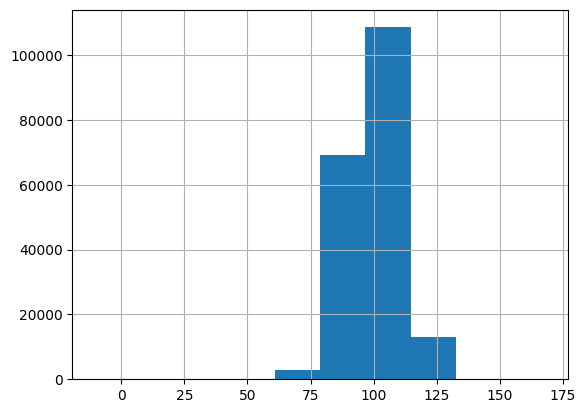

In [110]:
X_lhp['stuff+'].hist()

In [105]:
100 + (10 * (0.003394 - y_pred.mean() / y_pred.std()))

100.96623930790163

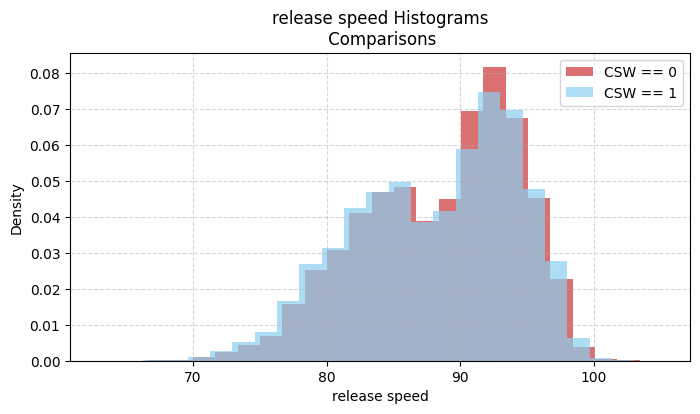

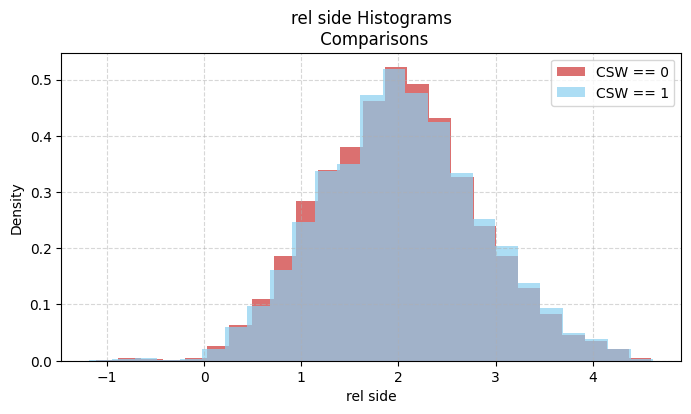

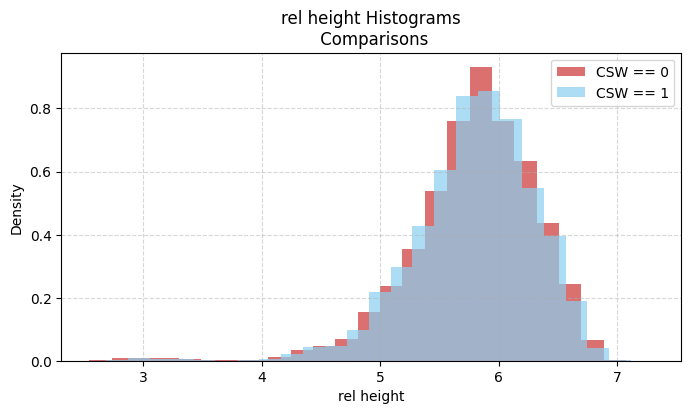

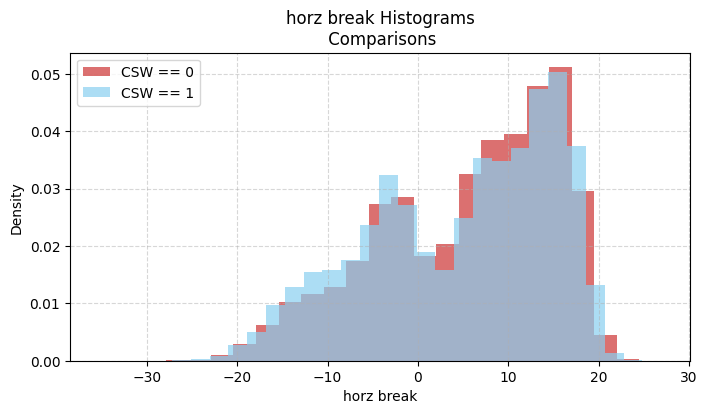

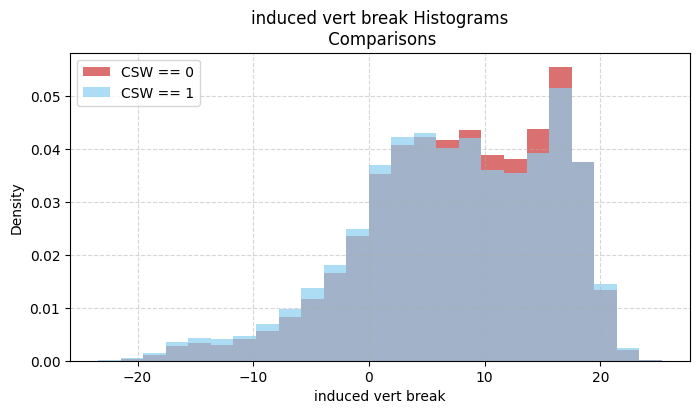

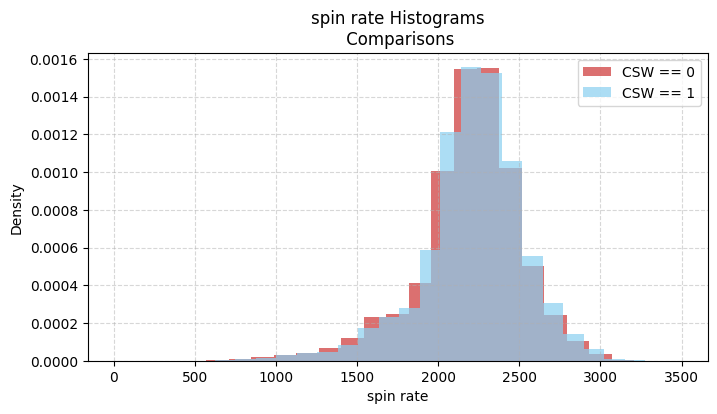

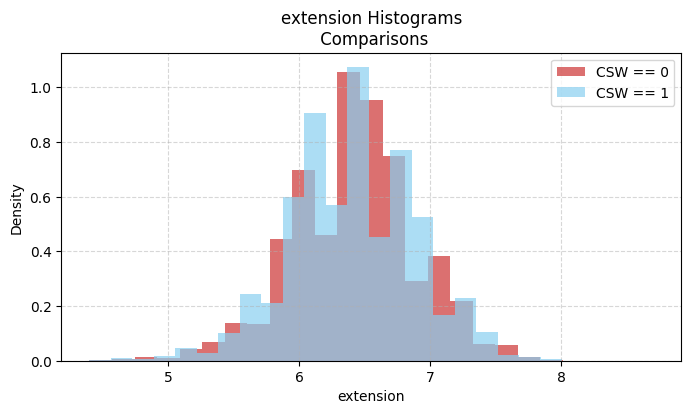

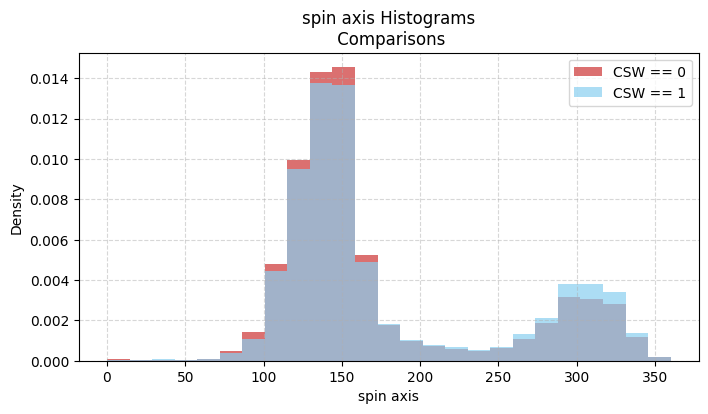

In [79]:
for i in ['release_speed', 'rel_side', 'rel_height', 'horz_break', 'induced_vert_break', 'spin_rate', 'extension', 'spin_axis']:
    catch_made_hist(lhp_pitches, i)

### LHP